In [1]:
# model data (?)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/home/tarasenko/prj/posada3/') #last version on my computer
from posada.Common import distancelib
from posada.Common.comfuncs import imresize
from posada.Common.imports import *
from posada.Extractors.resampler import Resampler
from posada.Handlers.BaseHandler import BaseHandler
from posada.Handlers.wind import Wind
from posada.Models.Field import Field
from posada.Models.Variable import Variable
from posada.Models.grid import Grid
from posada.Readers.grib import GribFile

In [2]:
def interimModel(startTime, iPath_wind=None):
    """ERA_INTERIM model wind for given time."""
    iPath_wind = iPath_wind or '/media/SOLabNFS2/store/model/ERA_INTERIM/'

    # find the ERA Interim filename to open from startTime
    baseHour = floor((startTime.hour + 3 / 2) / 6) * 6
    baseHour = min(18, baseHour)

    eraFolderPath = startTime.strftime(
        "%Y") + '/' + startTime.strftime("%m") + '/' + startTime.strftime("%d") + '/'
    eraFileName = eraFolderPath + 'interim_' + \
        startTime.strftime("%Y-%m-%d") + '-t%.2i' % (baseHour) + 'z.grib'

    gf = GribFile(url=iPath_wind + eraFileName)

    g = Grid()
    g.load(gf)
    g.add_handler(Wind)

    return g

In [3]:
def ncepGFSmodel(startTime, iPath_wind=None):
    """NCEP GFS model wind for given time."""
    iPath_wind = iPath_wind or '/media/SOLabNFS2/store/model/ncep/gfs/' or '/media/SOLabNFS2/store/model/ncep_/gfs/'

    # find the ncep gfs filename to open from startTime
    baseHour = floor((startTime.hour + 3 / 2) / 6) * 6
    baseHour = min(18, baseHour)
    if startTime.hour - baseHour > 1.5:
        forecastHour = 3
    else:
        forecastHour = 0

    if startTime <= datetime(2014, 8, 19):
        ncepFileName = 'gfs' + startTime.strftime("%Y%m%d") + '/gfs.t' + '%.2d' % (
            baseHour) + 'z.master.grbf' + '%.2d' % (forecastHour)
    else:
        ncepFileName = 'gfs.' + startTime.strftime("%Y%m%d") + '%.2d' % (baseHour) + '/gfs.t' + '%.2d' % (
            baseHour) + 'z.master.grbf' + '%.2d' % (forecastHour) + '.10m.uv.grib2'
        if os.path.isfile(iPath_wind + ncepFileName):
            pass
        else:
            ncepFileName = 'gfs.' + startTime.strftime("%Y%m%d") + '%.2d' % (
                baseHour) + '/gfs.t' + '%.2d' % (baseHour) + 'z.pgrb2.0p25.f' + '%.3d' % (forecastHour)

    gf = GribFile(url=iPath_wind + ncepFileName)

    g = Grid()
    g.load(gf)
    g.add_handler(Wind)

    return g

In [4]:
from datetime import datetime

t_str = datetime(2017, 3, 6, 21, 25, 43)
print (t_str)

g = ncepGFSmodel(t_str)


2017-03-06 21:25:43


In [19]:
# g.get_field_names()

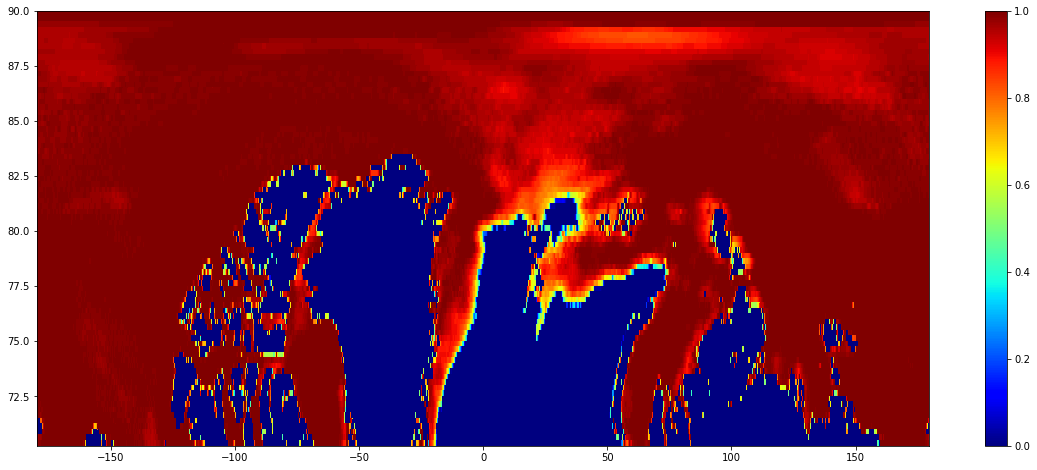

In [20]:
data_ncep = g.get_values('icec')
lat_ncep = g.get_values('lat')
lon_ncep = g.get_values('lon')


plt.figure(figsize=(20,8))
plt.pcolormesh(lon_ncep, lat_ncep[lat_ncep>70], data_ncep[lat_ncep>70], cmap = 'jet')
plt.colorbar()
plt.show()

In [81]:
pn = '/nfs1/store/satellite/sentinel-1/'
pol = 'hh'
resolution = 500    # in meters
fn = 'S1B_EW_GRDM_1SDH_20170305T051658_20170305T051803_004569_007F67_9DFE.zip'
import sys, os

# sys.path.append('/home/mag/Documents/repos/solab/POSADA/') #common version on student server
## sys.path.append('/home/tarasenko/codes/posada3/') #was old version (before switching to posada3 on python3)
sys.path.append('/home/tarasenko/prj/posada3/') #last version on my computer

from posada.Handlers import Sentinel_1 as SAR
from posada.Models import Swath
from posada.Readers import SAFE

from posada.Extractors.resampler import Resampler



sarf = SAFE(url=pn+fn, polarisation=pol)
sar = Swath()
sar.load(sarf)
sar.add_handler(SAR)
sar.set_spacing(sar.resolution2spacing(resolution))

sigma0 = sar.get_values('sigma0')
wdir_ncep = sar.get_values('wind_dir_ncep_gfs')-180
lat = sar.get_values('lat')
lon = sar.get_values('lon')


start_time = sar.get_start_time_dt()
ncep = ncepGFSmodel(start_time)
data_ncep = ncep.get_values('icec')
lat_ncep = ncep.get_values('lat')

/usr/local/lib/python3.4/dist-packages/pyresample/kd_tree.py:389: UserWarning: Possible more than 40 neighbours within 50000.0 m for some data points
  (neighbours, radius_of_influence))


In [83]:
ice_model = Resampler.resampleModel2Model(ncep, sar,
                                          ['icec'], numProcs=cpu_count() - 1,
                                          prefix='', resample_method='gaussian')


ice_resample = ice_model.get_values('icec')
ice = ncep.get_values('icec')



print(lat_ice.shape, ice_resample.shape, ice.shape)

/usr/local/lib/python3.4/dist-packages/pyresample/kd_tree.py:389: UserWarning: Possible more than 40 neighbours within 50000.0 m for some data points
  (neighbours, radius_of_influence))


(891, 861) (74, 72) (721, 1440)


In [75]:
sorted(ice_model.get_field_names())

['azimuth_time',
 'beta0',
 'beta0_lut',
 'complex',
 'digital_number',
 'doppler_centroid',
 'elevation',
 'gamma0',
 'gamma0_lut',
 'icec',
 'icec_ncep_gfs',
 'incidence',
 'lat',
 'lon',
 'mask',
 'nice_image',
 'roughness',
 'sigma0',
 'sigma0_lut',
 'slant_range_time',
 'wind_dir',
 'wind_dir_era_interim',
 'wind_dir_ncep_gfs',
 'wind_speed']

In [60]:
ice_resample = ice_model.get_values('icec')
lat_ice = ice_model.get_values('lat')


(891, 861) (74, 72)


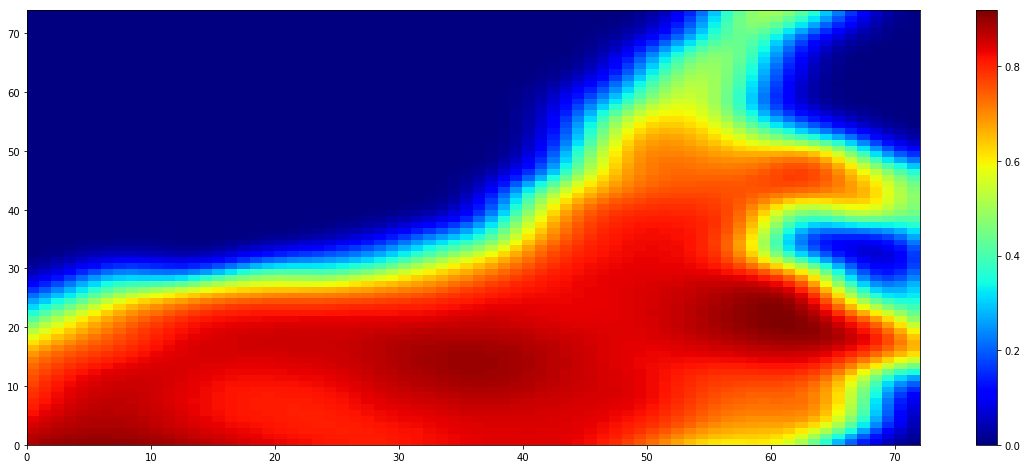

In [62]:

plt.figure(figsize=(20,8))
plt.pcolormesh(ll, cmap = 'jet')
plt.colorbar()
plt.show()


plt.figure(figsize=(20,8))
plt.pcolormesh(ll, cmap = 'jet')
plt.colorbar()
plt.show()